## Imbalanced data

The data is highly imbalanced when looking at the target LABEL feature. There are about 9% observations that were labeled as 1 (having readmission within 30 days). This high imabalance will lead to high accuracy (about 90%) even with a random classfier. However the recall and precision scores are low (even 0, in this case no positives, **1 here**, will be predicted in test dataset). Here I used several methods to oversample/undersample the classes of readmissions and obtain equal representation of overrepresented and underrepresented classes. Logistic regression classfier with hyperparameter grid search was used to evaluate different methods.
1. base
2. SMOTE (synthetic minority over-sampling technique)
3. RandomOverSampler
4. NearMiss
5. RandomUnderSampler
6. weighted base

The medod 1 has nothing to do with resampling. The methods 2 and 3 have oversampling on underrepresented class. The methods 4 and 5 have undersampling on overrepresented calss. Method 6 use `class_wight = 'balanced'` when implementing `LogisticRegression` calssifier.

The results show that, `base`, `RandomOverSampler`, `RandomUnderSampler`, `weighted base` have about 0.65 AUC score (area under curve). But `base` has very low recall score (0.002). `SMOTE` and `NearMiss` have about lower AUC score (about 0.57). `SMOTE` has low recall score (0.03) and `NearMiss` has low precision score (0.1). Then, `weighted base` method (use `class_weight = 'balanced'` in classfiers) will be used in later machinine learning practices (Random Forest, XGboost).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from sklearn.metrics import recall_score,accuracy_score,confusion_matrix, f1_score, precision_score, auc,roc_auc_score,roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids, NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('./data/diabetic_data_clean.csv', header=0)
df_original = df.copy
df.shape

(69973, 44)

In [3]:
df['age'] = df['age'].astype('object')
df['admission_type_id'] = df['admission_type_id'].astype('object')
df['discharge_disposition_id'] = df['discharge_disposition_id'].astype('object')
df['admission_source_id'] = df['admission_source_id'].astype('object')

In [4]:
df.dtypes

encounter_id                 int64
race                        object
gender                      object
age                         object
admission_type_id           object
discharge_disposition_id    object
admission_source_id         object
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide         

In [5]:
X = df.dropna()
y = X.LABEL
X.drop(['encounter_id','LABEL'], axis=1, inplace=True) #,'change','diabetesMed','num_change',
X.shape

C:\Program Files\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(68054, 42)

In [6]:
X = pd.get_dummies(X, drop_first=True)
print(X.shape)
print(y.shape)

(68054, 142)
(68054,)


### Check magnitude of data imbalance

In [7]:
count_classes = y.value_counts()
print(count_classes, '\n')
print(sum(y == 1)/len(y))

0    61918
1     6136
Name: LABEL, dtype: int64 

0.09016369353748493


In [8]:
#X = pd.DataFrame(StandardScaler().fit_transform(X))

### Split into training and test datasets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(54443, 142)
(13611, 142)


### Helper functions

In [10]:
def benchmark(sampling_type,X,y):
    lr = LogisticRegression(max_iter=1000, solver='liblinear')
    param_grid = {'C':[0.01,0.1,1,10,20]}
    gs = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=5, verbose=2)
    gs = gs.fit(X.values,y.values.ravel())
    return sampling_type,gs.best_score_,gs.best_params_['C']

def transform(transformer,X,y):
    print("Transforming {}".format(transformer.__class__.__name__))
    X_resampled,y_resampled = transformer.fit_sample(X.values,y.values.ravel())
    return transformer.__class__.__name__,pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)

### Apply transformations to dataset

In [11]:
datasets = []

datasets.append(("base",X_train,y_train))
datasets.append(transform(SMOTE(n_jobs=-1),X_train,y_train))
datasets.append(transform(RandomOverSampler(),X_train,y_train))
#datasets.append(transform(ClusterCentroids(n_jobs=-1),X_train,y_train))
datasets.append(transform(NearMiss(n_jobs=-1),X_train,y_train))
datasets.append(transform(RandomUnderSampler(),X_train,y_train))
#datasets.append(transform(SMOTEENN(),X_train,y_train))
#datasets.append(transform(SMOTETomek(),X_train,y_train))

Transforming SMOTE
Transforming RandomOverSampler
Transforming NearMiss
Transforming RandomUnderSampler


### Determine best hyperparameters

In [12]:
benchmark_scores = []
for sample_type,X,y in datasets:
    print('______________________________________________________________')
    print('{}'.format(sample_type))
    benchmark_scores.append(benchmark(sample_type,X,y))
    print('______________________________________________________________')

______________________________________________________________
base
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=   0.4s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.4s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.4s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.4s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.4s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.6s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.7s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   27.4s finished


______________________________________________________________
______________________________________________________________
SMOTE
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=   0.6s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.8s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.7s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.7s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.8s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   1.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   1.1s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   58.9s finished


______________________________________________________________
______________________________________________________________
RandomOverSampler
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ........................................... C=0.01, total=   0.9s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.9s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.9s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.9s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.9s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   1.5s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   1.3s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   1.4s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.4min finished


______________________________________________________________
______________________________________________________________
NearMiss
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.0s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    2.4s finished


______________________________________________________________
______________________________________________________________
RandomUnderSampler
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.1s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.01 ..........................................................
[CV] ........................................... C=0.01, total=   0.0s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................................ C=0.1, total=   0.1s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.6s finished


In [13]:
benchmark_scores

[('base', 0.9099057795755972, 0.01),
 ('SMOTE', 0.9295345085163481, 0.1),
 ('RandomOverSampler', 0.6120687837312541, 0.01),
 ('NearMiss', 0.8252707385861024, 20),
 ('RandomUnderSampler', 0.606180936423524, 1)]

In [14]:
scores = []
fpr_tpr = []

# train models based on benchmark params
for sampling_type,score,param in benchmark_scores:
    print("Training on {}".format(sampling_type))
    lr = LogisticRegression(solver='liblinear', C=param)
    for s_type, X, y in datasets:
        if s_type == sampling_type:
            lr.fit(X.values,y.values.ravel())
            pred_test = lr.predict(X_test.values)
            #pred_test_probs = lr.predict_proba(X_test.values)
            #probs = lr.decision_function(X_test.values)
            y_test_scores = lr.decision_function(X_test.values)
            fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)
            #p,r,t = precision_recall_curve(y_test.values.ravel(),probs)
            fpr_tpr.append((sampling_type, fpr, tpr))
            scores.append((sampling_type,
                           f1_score(y_test.values.ravel(),pred_test),
                           precision_score(y_test.values.ravel(),pred_test),
                           recall_score(y_test.values.ravel(),pred_test),
                           accuracy_score(y_test.values.ravel(),pred_test),
                           roc_auc_score(y_test, y_test_scores),
                           confusion_matrix(y_test.values.ravel(),pred_test)))

Training on base
Training on SMOTE
Training on RandomOverSampler
Training on NearMiss
Training on RandomUnderSampler


In [15]:
fpr_tpr_results = pd.DataFrame(fpr_tpr,columns=['Sampling Type','fpr','tpr'])
fpr_tpr_results

,Sampling Type,fpr,tpr
0,base,"[0.0, 0.0, 0.00016159004605316313, 0.000161590...","[0.0, 0.0008103727714748784, 0.000810372771474..."
1,SMOTE,"[0.0, 8.079502302658157e-05, 0.000484770138159...","[0.0, 0.0, 0.0, 0.0008103727714748784, 0.00081..."
2,RandomOverSampler,"[0.0, 0.0, 0.00016159004605316313, 0.000161590...","[0.0, 0.0008103727714748784, 0.000810372771474..."
3,NearMiss,"[0.0, 8.079502302658157e-05, 0.000565565161186...","[0.0, 0.0, 0.0, 0.0008103727714748784, 0.00081..."
4,RandomUnderSampler,"[0.0, 0.0, 0.00016159004605316313, 0.000161590...","[0.0, 0.0008103727714748784, 0.000810372771474..."


In [16]:
sampling_results = pd.DataFrame(scores,columns=['Sampling Type','f1','precision','recall','accuracy','auc','confusion_matrix'])
sampling_results

,Sampling Type,f1,precision,recall,accuracy,auc,confusion_matrix
0,base,0.004835,0.428571,0.002431,0.909265,0.641311,"[[12373, 4], [1231, 3]]"
1,SMOTE,0.054795,0.140468,0.034036,0.893542,0.556691,"[[12120, 257], [1192, 42]]"
2,RandomOverSampler,0.223753,0.141132,0.539708,0.660495,0.645297,"[[8324, 4053], [568, 666]]"
3,NearMiss,0.179991,0.101431,0.798217,0.340607,0.574133,"[[3651, 8726], [249, 985]]"
4,RandomUnderSampler,0.219192,0.137895,0.534036,0.655058,0.643375,"[[8257, 4120], [575, 659]]"


In [17]:
lr = LogisticRegression(solver='liblinear', class_weight="balanced")
lr.fit(X_train.values,y_train.values.ravel())
scores = []
fpr_tpr = []
pred_test = lr.predict(X_test.values)
#pred_test_probs = lr.predict_proba(X_test.values)
#probs = lr.decision_function(X_test.values)
y_test_scores = lr.decision_function(X_test.values)
fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)
fpr_tpr.append(("weighted_base", fpr, tpr))
scores.append(("weighted_base",
                           f1_score(y_test.values.ravel(),pred_test),
                           precision_score(y_test.values.ravel(),pred_test),
                           recall_score(y_test.values.ravel(),pred_test),
                           accuracy_score(y_test.values.ravel(),pred_test),
                           roc_auc_score(y_test, y_test_scores),
                           confusion_matrix(y_test.values.ravel(),pred_test)))

fpr_tpr = pd.DataFrame(fpr_tpr,columns=['Sampling Type','fpr','tpr'])
scores = pd.DataFrame(scores,columns=['Sampling Type','f1','precision','recall','accuracy','auc','confusion_matrix'])

In [19]:
fpr_tpr_results = fpr_tpr_results.append(fpr_tpr)
fpr_tpr_results

,Sampling Type,fpr,tpr
0,base,"[0.0, 0.0, 0.00016159004605316313, 0.000161590...","[0.0, 0.0008103727714748784, 0.000810372771474..."
1,SMOTE,"[0.0, 8.079502302658157e-05, 0.000484770138159...","[0.0, 0.0, 0.0, 0.0008103727714748784, 0.00081..."
2,RandomOverSampler,"[0.0, 0.0, 0.00016159004605316313, 0.000161590...","[0.0, 0.0008103727714748784, 0.000810372771474..."
3,NearMiss,"[0.0, 8.079502302658157e-05, 0.000565565161186...","[0.0, 0.0, 0.0, 0.0008103727714748784, 0.00081..."
4,RandomUnderSampler,"[0.0, 0.0, 0.00016159004605316313, 0.000161590...","[0.0, 0.0008103727714748784, 0.000810372771474..."
0,weighted_base,"[0.0, 0.0, 0.00016159004605316313, 0.000161590...","[0.0, 0.0008103727714748784, 0.000810372771474..."


In [20]:
sampling_results = sampling_results.append(scores)
sampling_results

,Sampling Type,f1,precision,recall,accuracy,auc,confusion_matrix
0,base,0.004835,0.428571,0.002431,0.909265,0.641311,"[[12373, 4], [1231, 3]]"
1,SMOTE,0.054795,0.140468,0.034036,0.893542,0.556691,"[[12120, 257], [1192, 42]]"
2,RandomOverSampler,0.223753,0.141132,0.539708,0.660495,0.645297,"[[8324, 4053], [568, 666]]"
3,NearMiss,0.179991,0.101431,0.798217,0.340607,0.574133,"[[3651, 8726], [249, 985]]"
4,RandomUnderSampler,0.219192,0.137895,0.534036,0.655058,0.643375,"[[8257, 4120], [575, 659]]"
0,weighted_base,0.223698,0.141595,0.532415,0.664977,0.647808,"[[8394, 3983], [577, 657]]"


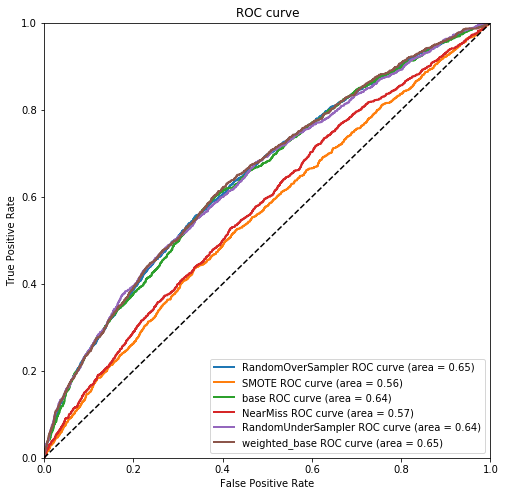

In [21]:
plt.figure(figsize=(8,8))

for i in set(fpr_tpr_results['Sampling Type']):
    plt.plot(fpr_tpr_results.fpr[fpr_tpr_results['Sampling Type'] == i].values[0], 
             fpr_tpr_results.tpr[fpr_tpr_results['Sampling Type'] == i].values[0], 
             label='{} ROC curve (area = {:.2f})'.format(i, sampling_results.auc[sampling_results['Sampling Type'] == i].values[0]),
             linewidth = 2)

plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()